In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



In [41]:
# Sample classification of players (this should be updated with accurate roles)
player_roles = {
    "Morgan": "Midfielder", "Forsberg": "Midfielder", "Manoel": "Attacker", "Harper": "Attacker", "Vanzeir": "Attacker", "Carmona": "Midfielder",
    "Gjengaar": "Attacker", "Hall": "Attacker", "Tolkin": "Defender", "Amaya": "Midfielder", "Burke": "Attacker", "Carballo": "Midfielder",
    "Duncan": "Defender", "Ngoma": "Attacker", "Reyes": "Defender", "Estrela": "Midfielder", "Marcucci": "Goalkeeper", "Mitchell": "Attacker",
    "O'Connor": "Defender", "Odle": "Goalkeeper", "Ofori": "Defender", "Rosborough": "Midfielder", "Sofo": "Attacker", "Sserwadda": "Midfielder",
    "Valencia": "Defender", "Alexandre": "Defender", "Coronel": "Goalkeeper", "Donkor": "Midfielder", "Edelman": "Midfielder", "Eile": "Defender",
    "Kasule": "Midfielder", "Meara": "Goalkeeper", "Meyer": "Goalkeeper", "Mina": "Defender", "Mullings": "Attacker", "Nealis": "Defender",
    "Nealis": "Defender", "Shapiro-Thompson": "Midfielder", "Stokes": "Goalkeeper", "Stroud": "Midfielder",
    "Martínez": "Attacker", "Rodríguez": "Midfielder", "Wolf": "Attacker", "Bakrar": "Attacker", "Ojeda": "Attacker", "Perea": "Midfielder",
    "Fernández": "Attacker", "Parks": "Midfielder", "Gray": "Defender", "Ilenic": "Defender", "Jones": "Attacker", "Magno": "Attacker",
    "Thiago": "Defender", "Moralez": "Midfielder", "O'Toole": "Attacker", "Sands": "Midfielder", "Arroyave": "Midfielder", "Baiera": "Defender",
    "Carrizo": "Midfielder", "Elias": "Midfielder", "Hope-Gund": "Defender",  "Jasson": "Midfielder", "Acevedo": "Midfielder", "Andrade": "Attacker",
    "Barraza": "Goalkeeper", "Benalcazar": "Defender", "Denis": "Attacker", "Freese": "Goalkeeper", "Haak": "Midfielder", "McFarlane": "Defender",
    "Mijatovic": "Attacker", "Mizell": "Goalkeeper", "Morales": "Midfielder", "Owusu": "Defender", "Pellegrini": "Midfielder", "Rando": "Goalkeeper",
    "Risa": "Defender", "Romero": "Goalkeeper", "Segal": "Attacker", "Shore": "Midfielder", "Tanasijević": "Defender", "Turnbull": "Defender",
    "Yañez": "Attacker", "Martins": "Midfielder", "Tanasijevic": "Defender"
}

In [42]:
# Load player stats data for 2024 mls games
rbny_avg_season = pd.read_excel('rbny_stats_2024/files/avg_mls_stats.xlsx')
nyc_avg_season = pd.read_excel('nycfc_stats_2024/files/avg_mls_stats.xlsx')

# Load the game-specific data for RBNY and NYC
rbny_game = pd.read_excel('rbny_stats_2024/files/game_stats_sept_18.xlsx')
nyc_game = pd.read_excel('nycfc_stats_2024/files/game_stats_sept_18.xlsx')

# Add 'Team' column to distinguish the team of each player
rbny_avg_season['Team'] = 'RBNY'
rbny_game['Team'] = 'RBNY'

nyc_avg_season['Team'] = 'NYCFC'
nyc_game['Team'] = 'NYCFC'

# Concatenate the two datasets into one
combined_season = pd.concat([rbny_avg_season, nyc_avg_season], ignore_index=True)
combined_game = pd.concat([rbny_game, nyc_game], ignore_index=True)

# Add role column based on the player names and player_roles
combined_season['Role'] = combined_season['Last Name'].map(player_roles)
combined_game['Role'] = combined_game['Last Name'].map(player_roles)

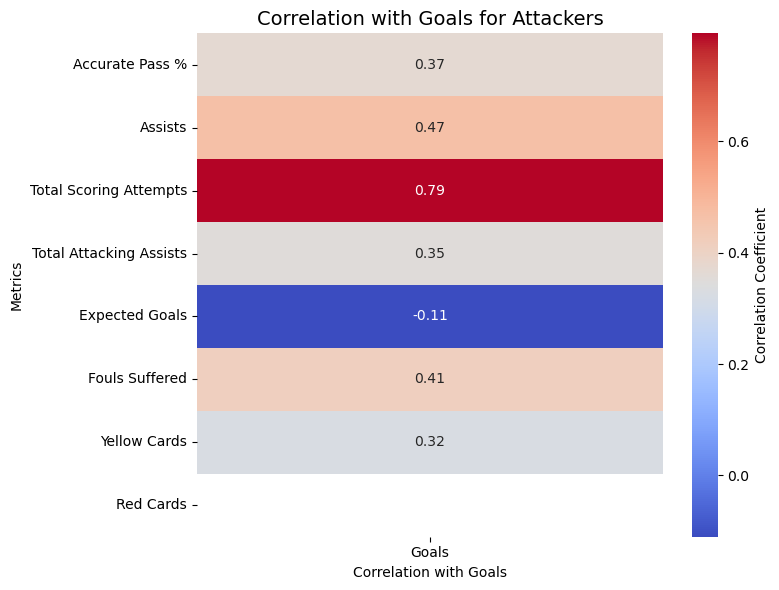

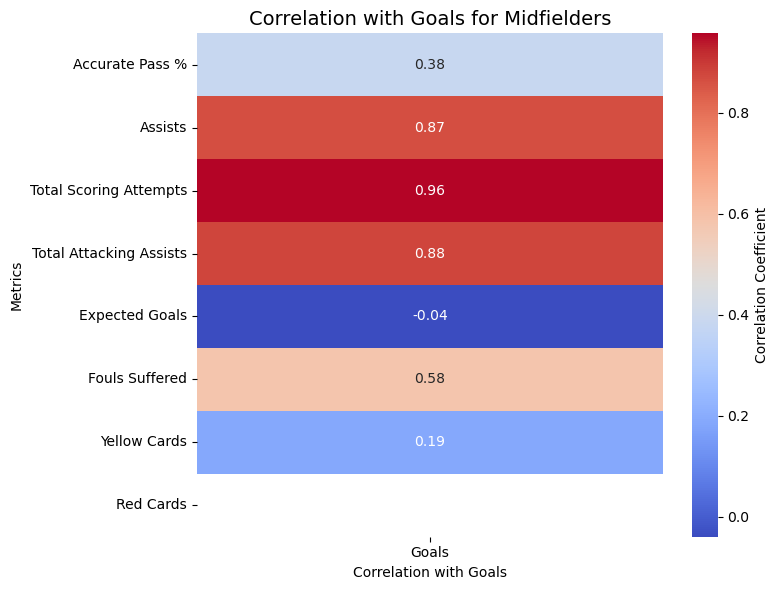

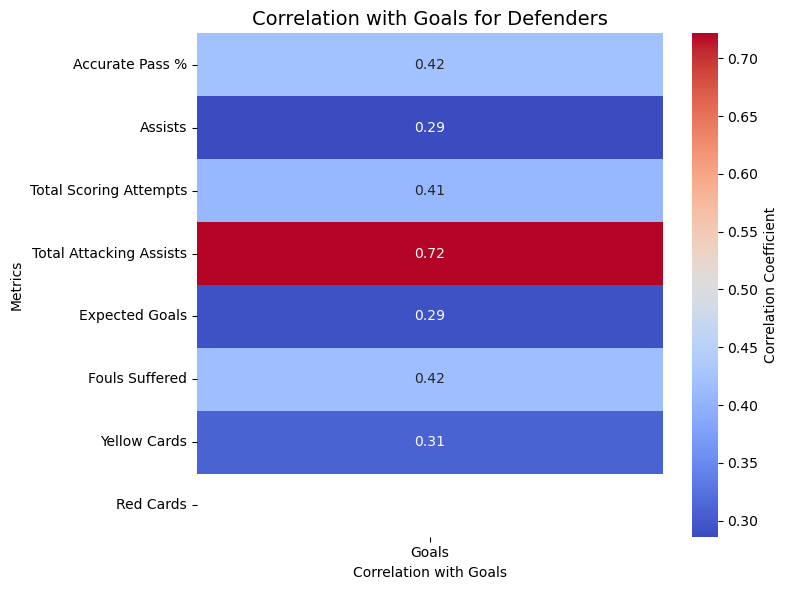

In [43]:
# Filter to keep only numeric columns
columns_to_plot = [col for col in combined_season.columns.intersection(combined_game.columns) if pd.api.types.is_numeric_dtype(combined_season[col])]

# Filter data by Role
roles = ['Attacker', 'Midfielder', 'Defender']

# Plot correlation heatmap for each role
for role in roles:
    # Filter data for the current role
    role_data = combined_season[combined_season['Role'] == role]
    
    # Compute correlation matrix
    corr_matrix = role_data[columns_to_plot].corr()
    
    # Focus on 'Goals' correlation
    corr_with_goals = corr_matrix[['Goals']].drop(index='Goals')
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_with_goals, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm', 
        cbar=True, 
        yticklabels=corr_with_goals.index, 
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    # Adjust layout and titles
    plt.title(f"Correlation with Goals for {role}s", fontsize=14)
    plt.ylabel("Metrics")
    plt.xlabel("Correlation with Goals")
    plt.tight_layout()
    plt.show()

In [44]:
# Load player stats data for 2024 mls games
rbny_season = pd.read_excel('rbny_stats_2024/files/season_stats_per_player.xlsx')
nyc_season = pd.read_excel('nycfc_stats_2024/files/season_stats_per_player.xlsx')


In [45]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Define role-specific columns
role_columns = {
    'Attacker': ['Total Scoring Attempts'],
    'Midfielder': ['Assists', 'Total Scoring Attempts', 'Total Attacking Assists'],
    'Defender': ['Total Attacking Assists']
}

# Initialize a list to store results
results = []

# Function to check normality and plot distributions
def check_normality(data, column):
    stat, p_value = shapiro(data[column].dropna())
    return p_value > 0.05, stat, p_value

# Perform statistics for each role and column
for role, columns in role_columns.items():
    role_data = combined_season[combined_season['Role'] == role]
    game_role_data = combined_game[combined_game['Role'] == role]
    
    for column in columns:
        # Check normality for season and game data
        season_normal, season_stat, season_p = check_normality(role_data, column)
        game_normal, game_stat, game_p = check_normality(game_role_data, column)
        
        # Perform statistical test between season and game data
        if season_normal and game_normal:
            # Use t-test
            test_name = "T-Test"
            stat, p_value = ttest_ind(role_data[column].dropna(), game_role_data[column].dropna())
        else:
            # Use Mann-Whitney U test
            test_name = "Mann-Whitney U Test"
            stat, p_value = mannwhitneyu(role_data[column].dropna(), game_role_data[column].dropna())
        
        # Determine conclusion
        conclusion = "Significant Difference" if p_value < 0.05 else "No Significant Difference"
        
        # Append results to the list
        results.append({
            'Role': role,
            'Metric': column,
            'Season Normal (P-Value)': season_p,
            'Game Normal (P-Value)': game_p,
            'Test Used': test_name,
            'Test Stat': stat,
            'P-Value': p_value,
            'Conclusion': conclusion
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Export results to an Excel file
output_file = "Player_Role_Analysis.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Analysis Results')
    print(f"Results saved to {output_file}")


Results saved to Player_Role_Analysis.xlsx


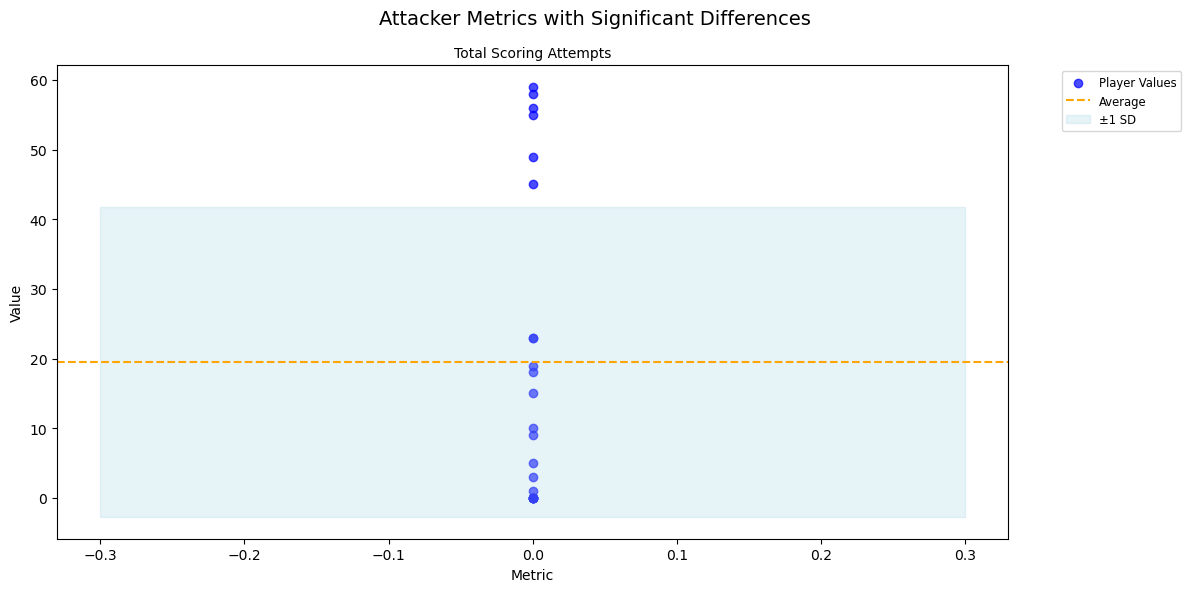

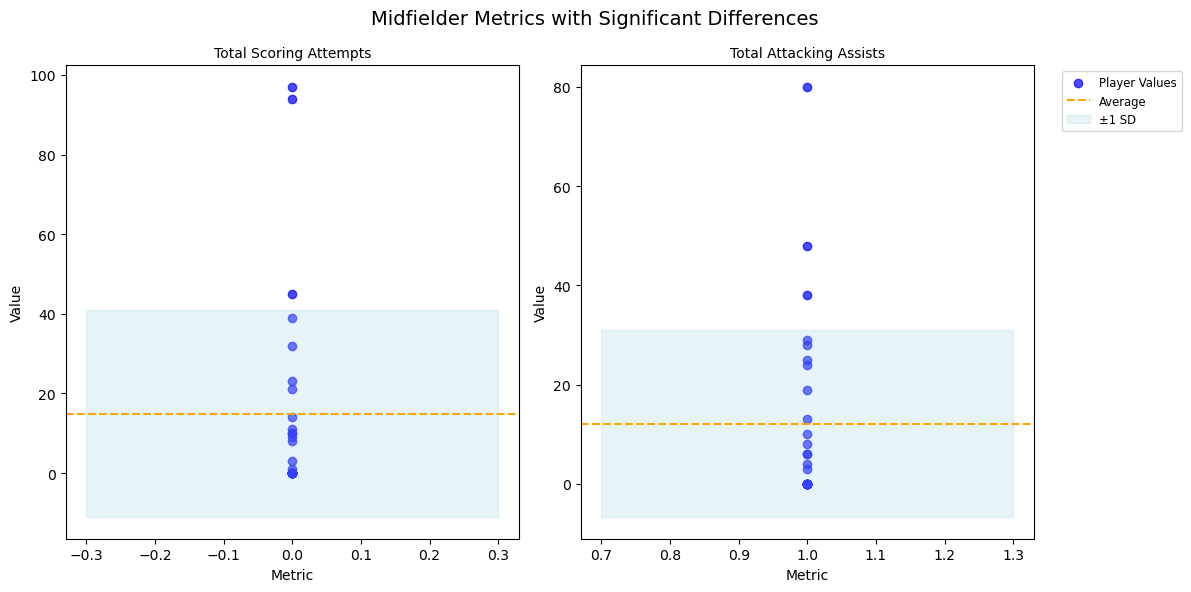

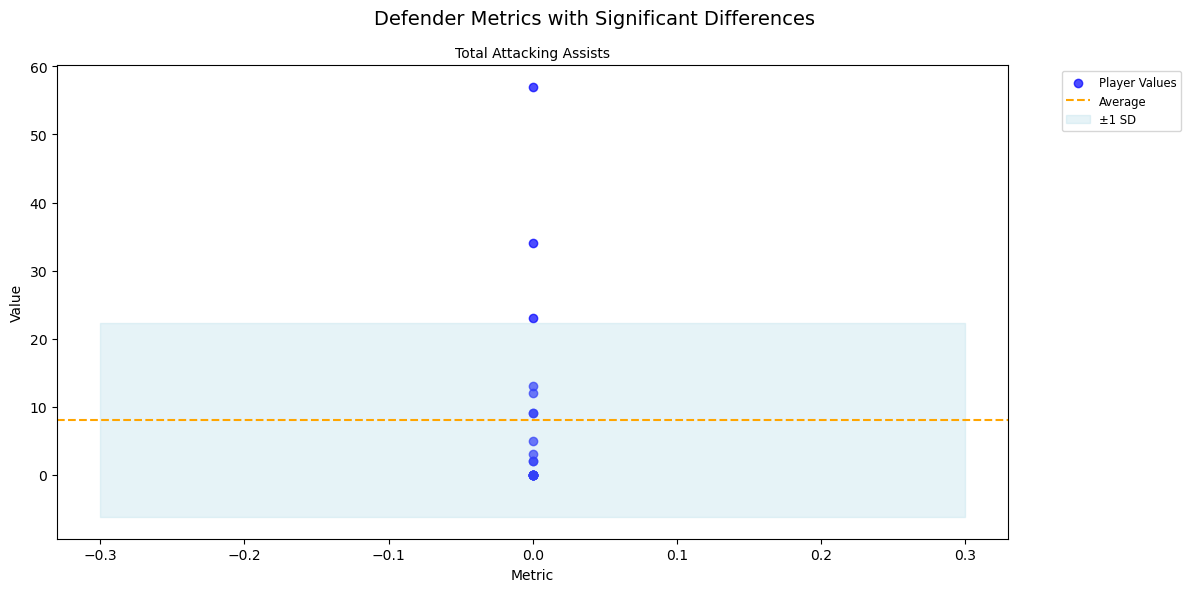

In [48]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()
        
        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values
        plt.scatter(
            x=np.full_like(metric_data, idx),  # All dots align to this metric's position
            y=metric_data,
            color='blue',
            label='Player Values',
            alpha=0.7
        )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()


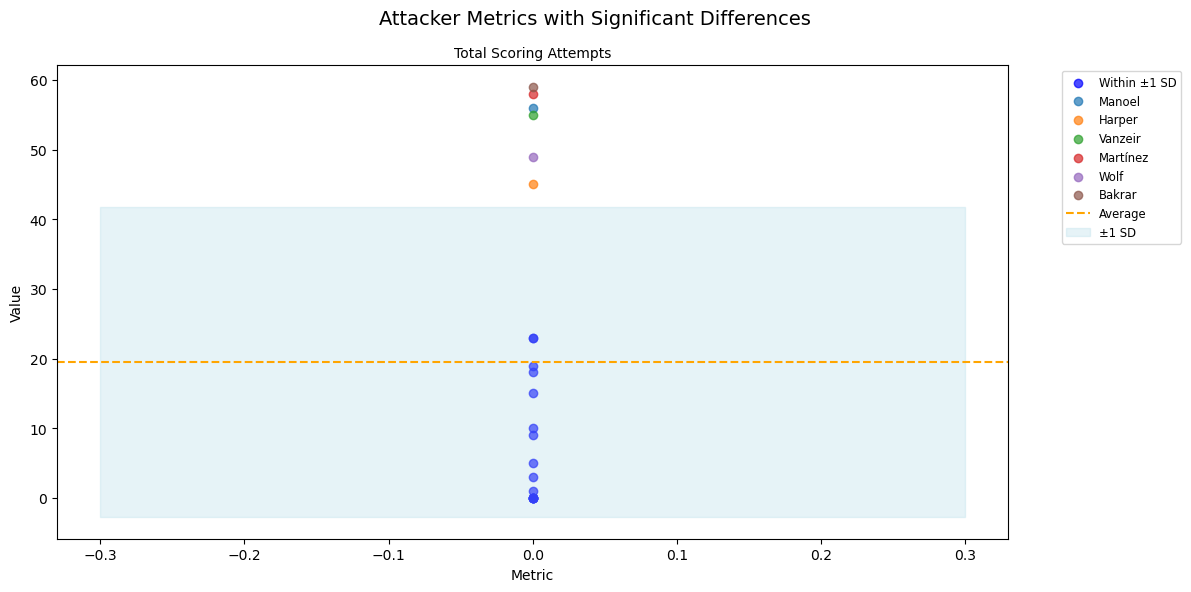

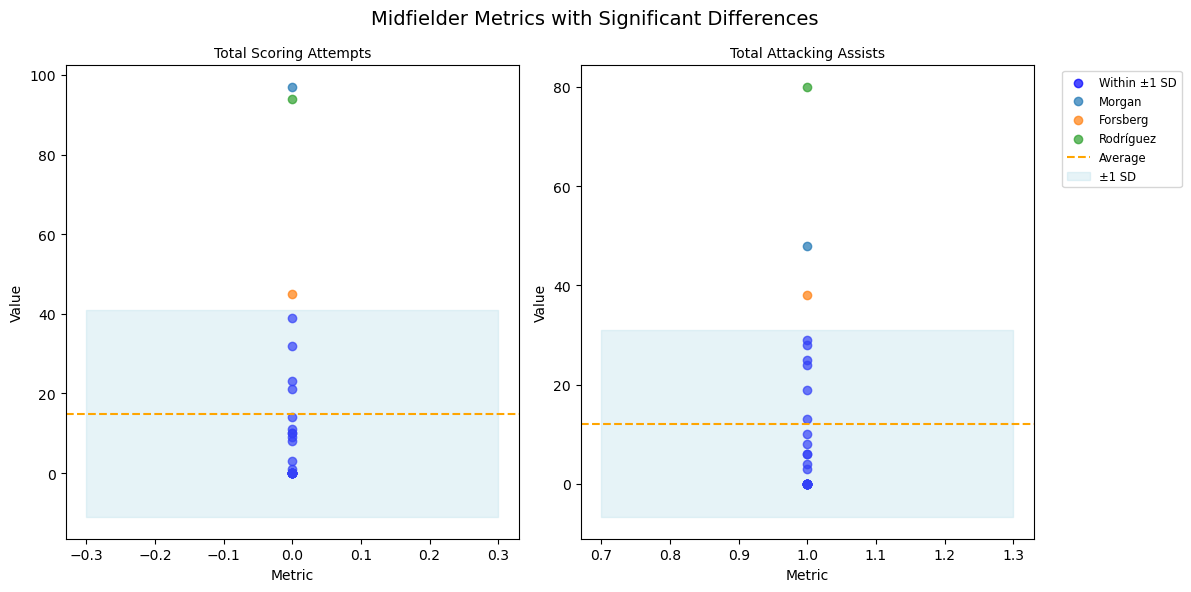

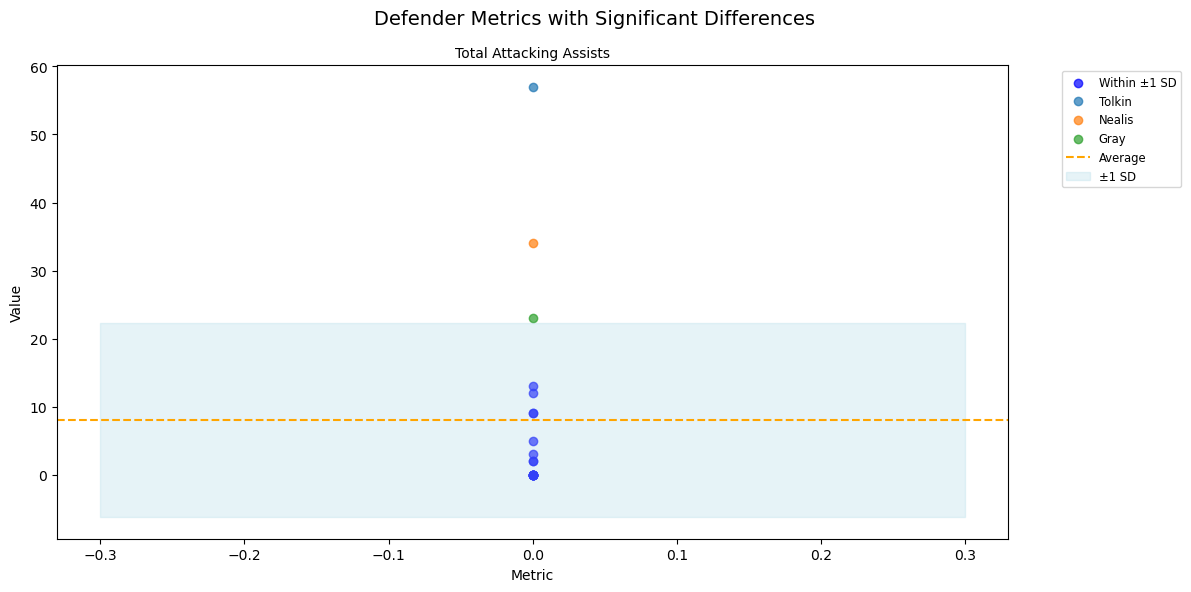

In [49]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()
        
        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values
        inside_std = []  # Players inside ±1 SD
        outside_std = []  # Players outside ±1 SD
        outside_names = []  # Names of players outside ±1 SD
        
        for i, value in enumerate(metric_data):
            player_name = role_data.iloc[i]['Last Name']  # Get player name
            if avg_value - std_dev <= value <= avg_value + std_dev:
                inside_std.append((idx, value))
            else:
                outside_std.append((idx, value))
                outside_names.append(player_name)

        # Plot players inside ±1 SD in blue
        if inside_std:
            inside_x, inside_y = zip(*inside_std)
            plt.scatter(
                x=inside_x,
                y=inside_y,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors
        for (x, y), name in zip(outside_std, outside_names):
            plt.scatter(
                x=[x],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()


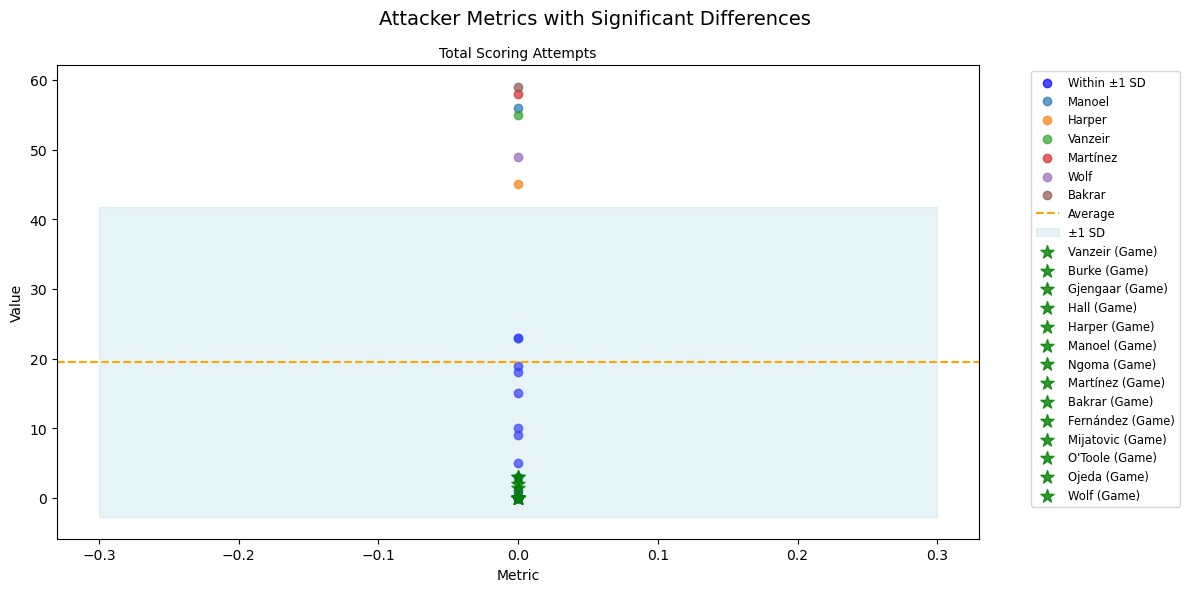

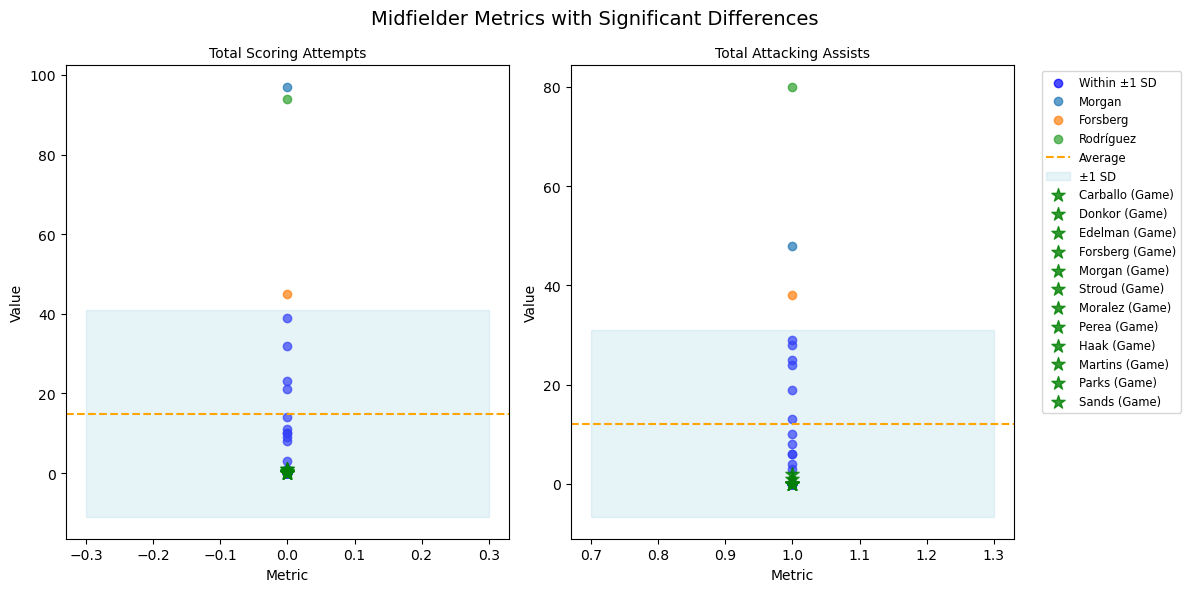

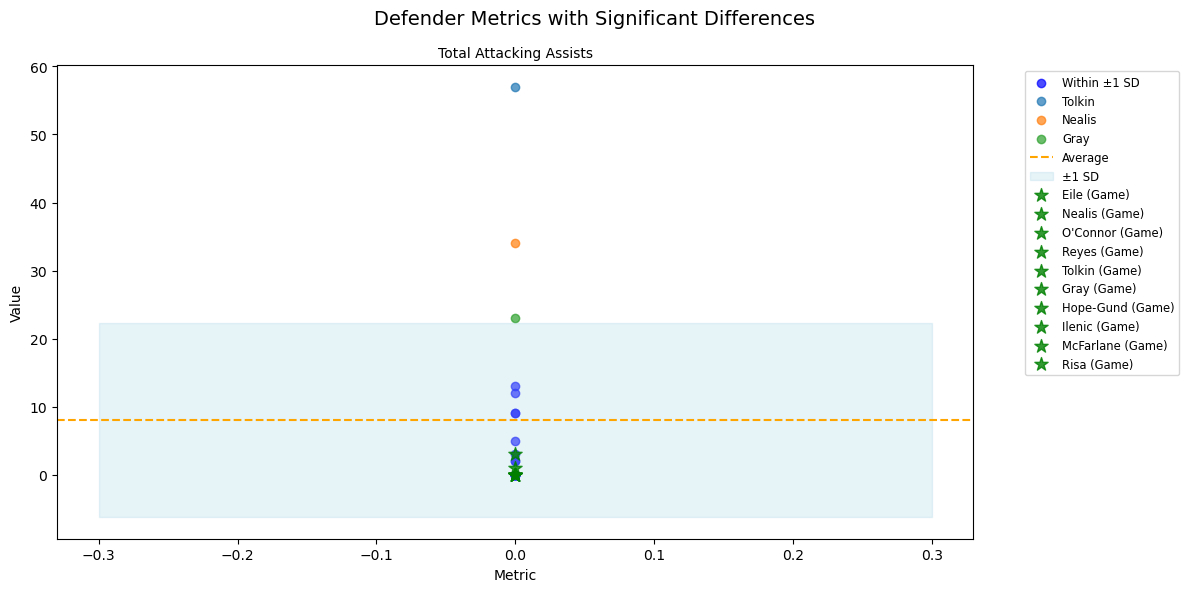

In [50]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    game_role_data = combined_game[combined_game['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        # Extract season data for the metric
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()

        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values (season data)
        inside_std = []  # Players inside ±1 SD
        outside_std = []  # Players outside ±1 SD
        outside_names = []  # Names of players outside ±1 SD

        for i, value in enumerate(metric_data):
            player_name = role_data.iloc[i]['Last Name']  # Get player name
            if avg_value - std_dev <= value <= avg_value + std_dev:
                inside_std.append((idx, value))
            else:
                outside_std.append((idx, value))
                outside_names.append(player_name)

        # Plot players inside ±1 SD in blue
        if inside_std:
            inside_x, inside_y = zip(*inside_std)
            plt.scatter(
                x=inside_x,
                y=inside_y,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors
        for (x, y), name in zip(outside_std, outside_names):
            plt.scatter(
                x=[x],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Plot stars for game-specific values
        game_metric_data = game_role_data[metric].dropna()  # Get game-specific values
        for i, value in enumerate(game_metric_data):
            if avg_value - std_dev <= value <= avg_value + std_dev:  # Inside SD
                plt.scatter(
                    x=[idx],  # Keep same x position for the metric
                    y=[value],
                    color='green',
                    marker='*',  # Star marker
                    label=f"{game_role_data.iloc[i]['Last Name']} (Game)",
                    s=100,  # Larger size for stars
                    alpha=0.8
                )
            else:  # Outside SD
                plt.scatter(
                    x=[idx],
                    y=[value],
                    color='red',
                    marker='*',
                    label=f"{game_role_data.iloc[i]['Last Name']} (Game)",
                    s=100,  # Larger size for stars
                    alpha=0.8
                )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()
